In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Build the model

For the given dataset we have found out, that a one hidden layer dense network consisting of 397 relu activation units gets best results.

In [3]:
class MNIST:
    def __init__(self):
        self.session = tf.Session()

    def data(self, images, labels, batch_size=64, prefetch_buffer=128):
        with tf.variable_scope("data"):
            dataset = tf.data.Dataset.from_tensor_slices((images, labels))
            dataset = dataset.shuffle(buffer_size=20000, seed=12345).repeat()
            dataset = dataset.batch(batch_size)
            dataset = dataset.prefetch(prefetch_buffer)
            iterator = dataset.make_one_shot_iterator()
        return iterator

    def model(self, images, hidden1_units=397):
        with tf.variable_scope('hidden1', reuse=tf.AUTO_REUSE):
            weights = tf.get_variable(name='weights', shape=(28 * 28, hidden1_units), dtype=tf.float32,
                                      initializer=tf.contrib.layers.xavier_initializer())
            biases = tf.get_variable(name='biases', shape=hidden1_units, dtype=tf.float32,
                                     initializer=tf.initializers.zeros())
        hidden1 = tf.nn.relu(tf.add(tf.matmul(images, weights), biases))
        with tf.variable_scope('softmax', reuse=tf.AUTO_REUSE):
            weights = tf.get_variable(name='weights', shape=(hidden1_units, 10), dtype=tf.float32,
                                      initializer=tf.contrib.layers.xavier_initializer())
            biases = tf.get_variable(name='biases', shape=10, initializer=tf.initializers.zeros())
        return tf.add(tf.matmul(hidden1, weights), biases)

    def loss(self, logits, labels):
        with tf.variable_scope("loss"):
            return tf.losses.sparse_softmax_cross_entropy(labels, logits)

    def optimizer(self, loss):
        with tf.variable_scope("optimizer"):
            optimizer = tf.train.AdamOptimizer()
            optimizer = optimizer.minimize(loss)
        return optimizer

    def performance_metric(self, logits, labels):
        with tf.variable_scope("performance_metric"):
            preds = tf.argmax(logits, axis=1)
            labels = tf.cast(labels, tf.int64)
            corrects = tf.equal(preds, labels)
            accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))
        return accuracy

    def fit(self, _images, _labels, n_epochs=20, batch_size=64):
        images, labels = self.data(_images, _labels, batch_size).get_next()
        logits = self.model(images)
        loss = self.loss(logits, labels)
        optimizer = self.optimizer(loss)
        accuracy = self.performance_metric(logits, labels)
        self.session.run(tf.global_variables_initializer())
        _loss, _acc = 0, 0
        epoch = _images.shape[0] / batch_size
        n_iters = int((_images.shape[0] / batch_size) * n_epochs)
        history = dict(loss=[], accuracy=[], n_epochs=n_epochs)

        for i in range(1, n_iters + 1):
            _, loss_batch, acc_batch = self.session.run([optimizer, loss, accuracy])
            _loss += loss_batch
            _acc += acc_batch
            if i % epoch == 0:
                _loss /= epoch
                _acc /= epoch
                print('Epoch %2d, loss %.4f, accuracy %.2f%%' % (i / epoch, _loss, _acc * 100))
                history['loss'].append(_loss)
                history['accuracy'].append(_acc)
                _acc, _loss = 0, 0

        return history

    def eval(self, images, labels):
        logits = self.model(images)
        loss = self.loss(logits, labels)
        accuracy = self.performance_metric(logits, labels)

        val_loss, val_acc = self.session.run([loss, accuracy])
        print('Validation loss %.4f, accuracy %.2f%%' % (val_loss, val_acc * 100))
        
    def predict(self, images):
        pred = tf.argmax(tf.nn.softmax(self.model(images)), axis=1)
        return pred.eval(session=self.session)

### Prepare the data

In [4]:
with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

In [5]:
# Rescale the data to range (0,1) for numerical stability
data_x /= 255.0
test_x /= 255.0
data_x = data_x.reshape(data_x.shape[0], 28 * 28)
test_x = test_x.reshape(test_x.shape[0], 28 * 28)

In [6]:
# Use 80/20 ratio for train and validation
train_X, train_y = data_x[:16000], data_y[:16000]
val_X, val_y = data_x[16000:], data_y[16000:]

### Train the model

In [7]:
model = MNIST()
history = model.fit(train_X, train_y)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch  1, loss 0.4195, accuracy 88.09%
Epoch  2, loss 0.1894, accuracy 94.58%
Epoch  3, loss 0.1288, accuracy 96.26%
Epoch  4, loss 0.0925, accuracy 97.34%
Epoch  5, loss 0.0615, accuracy 98.35%
Epoch  6, loss 0.0473, accuracy 98.82%
Epoch  7, loss 0.0344, accuracy 99.15%
Epoch  8, loss 0.0242, accuracy 99.50%
Epoch  9, loss 0.0186, accuracy 99.66%
Epoch 10, loss 0.0128, accuracy 99.83%
Epoch 11, loss 0.0090, accuracy 99.89%
Epoch 12, loss 0.0058, accuracy 99.98%
Epoch 13, loss 0.0046, accuracy 99.98%
Epoch 14, loss 0.0040, accuracy 99.98%
Epoch 15, loss 0.0029, accuracy 99.99%
Epoch 16, loss 0.0021, accuracy 100.00%
Epoch 17, loss 0.00

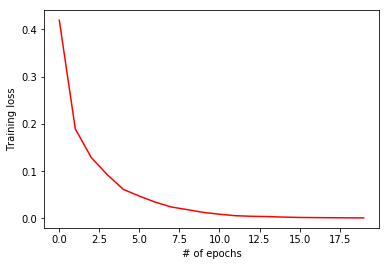

In [8]:
plt.plot(np.arange(0, history['n_epochs']), history['loss'], 'r')
plt.xlabel('# of epochs')
plt.ylabel('Training loss')
plt.show()

### Evaluate the performance on the validation data

In [9]:
model.eval(val_X, val_y)

Validation loss 0.1050, accuracy 97.32%


### Predict

In [10]:
prediction = model.predict(test_x)

assert prediction.ndim == 1
assert prediction.shape[0] == 2000
np.save('prediction.npy', prediction)

### Compare some predicted numbers with test data

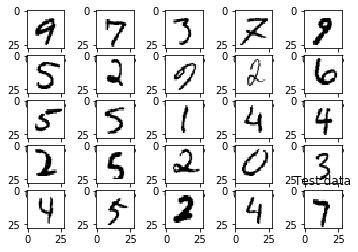

Predicion: 
 [[9 7 3 7 9]
 [5 2 9 2 6]
 [5 5 1 4 4]
 [2 5 2 0 3]
 [4 9 2 4 7]]


In [16]:
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_x[i].reshape(28, 28), cmap=plt.cm.binary)
plt.title("Test data")
plt.show()

print("Predicion: \n", prediction[:25].reshape(5, 5))